In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IVGMM
from statsmodels.tsa.filters.hp_filter import hpfilter
from numpy.linalg import matrix_rank

# 샘플 데이터 생성 (일별 시계열 데이터)
n_days = 365
np.random.seed(42)

dates = pd.date_range(start='2024-01-01', periods=n_days, freq='D')

def skewed_distribution(mean, size, shape=2):
    scale = mean / shape
    return np.random.gamma(shape, scale, size)

data = {
    'date': dates,
    'd1_retention': skewed_distribution(0.6, n_days, shape=2),
    'd0_daily_play_minutes': skewed_distribution(30, n_days, shape=2),
    'd0_iap_user_ratio': skewed_distribution(0.01, n_days, shape=1),
    'd0_max_stage_level': np.clip(skewed_distribution(35, n_days, shape=2), 1, 100),
    'd0_quest_completion_rate': skewed_distribution(0.7, n_days, shape=2),
    'd0_soft_currency_get_amount_per_user': np.clip(skewed_distribution(50000, n_days, shape=2), 0, 100000),
    'd0_soft_currency_use_amount_per_user': np.clip(skewed_distribution(45000, n_days, shape=2), 0, 90000),
    'd0_hard_currency_get_amount_per_user': np.clip(skewed_distribution(5000, n_days, shape=2), 0, 10000),
    'd0_hard_currency_use_amount_per_user': np.clip(skewed_distribution(4500, n_days, shape=2), 0, 9000),
    'd0_avg_win_rate': skewed_distribution(0.9, n_days, shape=3),
    'd0_boss_success_rate': skewed_distribution(0.3, n_days, shape=2),
    'daily_active_users': np.random.normal(5000, 500, n_days),
    'new_users': np.random.normal(20000, 2000, n_days)
}

df = pd.DataFrame(data)


# d1_retention 값 재정의 (평균 0.6, 왼쪽으로 치우친 분포, 최소 0.2, 최대 0.8)
from scipy import stats

# 베타 분포를 사용하여 왼쪽으로 치우친 분포 생성
# 평균이 0.6이 되도록 알파와 베타 파라미터 설정
alpha = 2  # 알파 값이 작을수록 왼쪽으로 더 치우침
beta = 4/3  # 평균이 0.6이 되도록 베타 = 알파 * (1-평균)/평균

# 베타 분포에서 난수 생성
beta_samples = stats.beta.rvs(alpha, beta, size=n_days, random_state=42)

# 0.2~0.8 범위로 스케일링
df['d1_retention'] = 0.2 + (beta_samples * 0.6)

# 진행율 지표
df['progression_balance'] = (
    (df['d0_max_stage_level'] - df['d0_max_stage_level'].mean()) / df['d0_max_stage_level'].std() * 0.4 +
    (df['d0_quest_completion_rate'] - df['d0_quest_completion_rate'].mean()) / df['d0_quest_completion_rate'].std() * 0.4 +
    (-1 * (df['daily_active_users'] - df['daily_active_users'].mean()) / df['daily_active_users'].std() * 0.2)
)

# 게임 난이도 지표
df['difficulty_balance'] = (
    (-1 * abs(df['d0_avg_win_rate'] - 0.5) / df['d0_avg_win_rate'].std() * 0.4) +
    (df['d0_boss_success_rate'] - df['d0_boss_success_rate'].mean()) / df['d0_boss_success_rate'].std() * 0.3)

df.set_index('date', inplace=True)
df['holiday'] = (df.index.dayofweek >= 5).astype(int)

# HP 필터 적용
lamb = 129600

# 경제 지표
df['soft_currency_ratio'] = (df['d0_soft_currency_get_amount_per_user'] - df['d0_soft_currency_use_amount_per_user']) / df['d0_soft_currency_get_amount_per_user']
df['hard_currency_ratio'] = (df['d0_hard_currency_get_amount_per_user'] - df['d0_hard_currency_use_amount_per_user']) / df['d0_hard_currency_get_amount_per_user']

for col in ['soft_currency_ratio', 'hard_currency_ratio']:
    cycle, trend = hpfilter(df[col].fillna(0), lamb=lamb)
    df[f'{col}_gap'] = (df[col] - trend) * 100  # 갭 계산

# 가중치 조정: 소프트 & 하드 화폐 균형 (50:50)
df['economy_balance'] = (df['soft_currency_ratio_gap'] * 0.5) + (df['hard_currency_ratio_gap'] * 0.5)

for balance in ['progression_balance', 'economy_balance', 'difficulty_balance', 'new_users', 'd0_iap_user_ratio']:
    cycle, trend = hpfilter(df[balance], lamb=lamb)
    df[f'{balance}_potential'] = trend
    df[f'{balance}_gap'] = (df[balance] - df[f'{balance}_potential']) * 100

df.fillna(0, inplace=True)

# 도구 변수 설정 (1~10일 전 값 활용)
for lag in range(1, 10):
    df[f'progression_balance_lag{lag}'] = df['progression_balance_gap'].shift(lag)
    df[f'economy_balance_lag{lag}'] = df['economy_balance_gap'].shift(lag)
    df[f'difficulty_balance_lag{lag}'] = df['difficulty_balance_gap'].shift(lag)


# 기존 샘플 데이터 생성 후 d1_retention을 갱신
df['d1_retention'] = (
    99 * df['progression_balance_gap'] +  # 변수 영향력 증가
    0.3 * df['economy_balance_gap'] +      # 변수 영향력 증가
    99 * df['difficulty_balance_gap'] +   # 변수 영향력 증가
    0.15 * df['holiday'] +                  # holiday 변수 영향력 유지
    np.random.normal(0, 0.1, n_days) +      # 노이즈 감소
    0.6                                     # 평균 유지
)

# 분포 조정 - 스케일링과 클리핑 적용
min_val = df['d1_retention'].min()
max_val = df['d1_retention'].max()
# 현재 범위에서 목표 범위(0.2~0.8)로 스케일링
df['d1_retention'] = 0.2 + ((df['d1_retention'] - min_val) / (max_val - min_val)) * 0.6

# 혹시 이상치로 인해 범위를 벗어나는 값이 있다면 최종 클리핑
df['d1_retention'] = df['d1_retention'].clip(0.2, 0.8)

# 원래 값과 랜덤한 값을 혼합
random_vals = np.random.beta(2, 1.3, len(df)) * 0.6 + 0.2
df['d1_retention'] = df['d1_retention'] * 0.8 + random_vals * 0.2

# 최종 클리핑
df['d1_retention'] = df['d1_retention'].clip(0.2, 0.8)


df.fillna(0, inplace=True)

# 종속 변수
y = df['d1_retention']

# 외생 설명 변수 (holiday를 0 또는 1의 더미 변수로 활용)
X = df[['new_users_gap', 'd0_iap_user_ratio_gap', 'holiday']]
X = sm.add_constant(X)

# 내생 변수
endog = df[['progression_balance_gap', 'economy_balance_gap', 'difficulty_balance_gap']]

# 도구 변수 설정
Z = df[[col for col in df.columns if 'lag' in col]]

# 데이터 크기 정렬
y, X = y.align(X, join='inner', axis=0)
y, endog = y.align(endog, join='inner', axis=0)
y, Z = y.align(Z, join='inner', axis=0)

# 행렬의 랭크 확인
if matrix_rank(X.to_numpy()) < X.shape[1] or matrix_rank(Z.to_numpy()) < Z.shape[1]:
    raise ValueError("독립 변수나 도구 변수가 선형 종속성을 가집니다. 컬럼을 확인하세요.")

# GMM 모델 실행
model = IVGMM(y, X, endog, instruments=Z)
results = model.fit()

print(results.summary)


                          IV-GMM Estimation Summary                           
Dep. Variable:           d1_retention   R-squared:                      0.8148
Estimator:                     IV-GMM   Adj. R-squared:                 0.8117
No. Observations:                 365   F-statistic:                    219.13
Date:                Wed, Mar 05 2025   P-value (F-stat)                0.0000
Time:                        03:46:12   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.5751     0.0018     323.18     0.0000      0.5716      0.5786


📊 모델 성능 지표:
MSE: 0.0009
RMSE: 0.0297
결정계수(R-squared): 0.8148


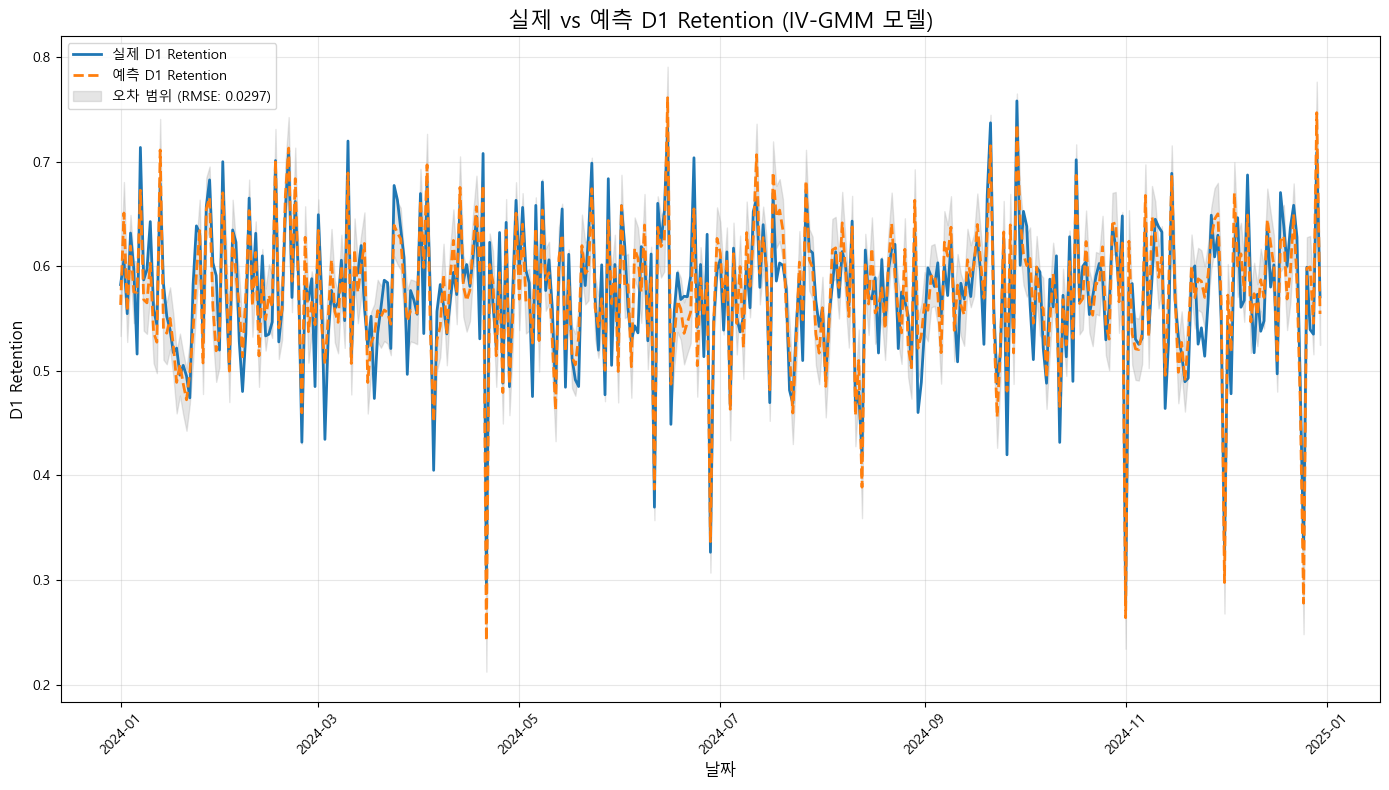

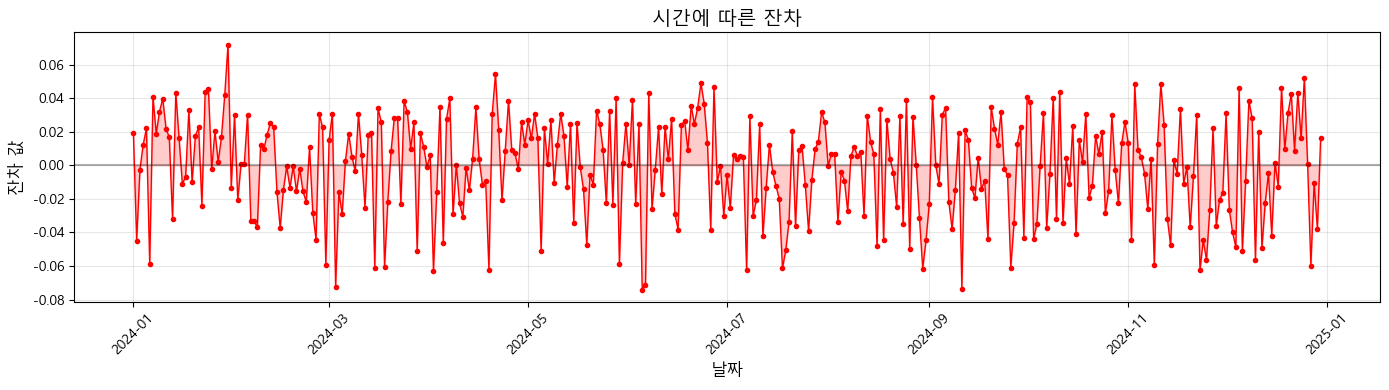

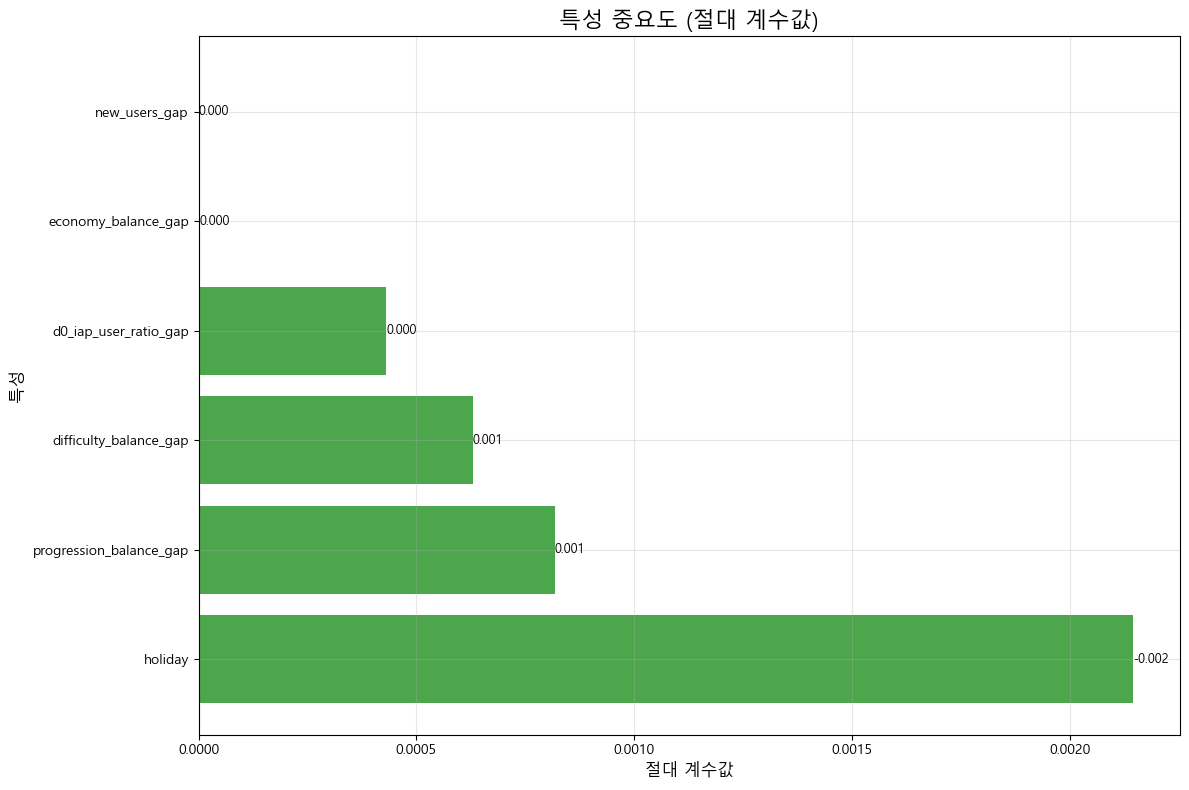

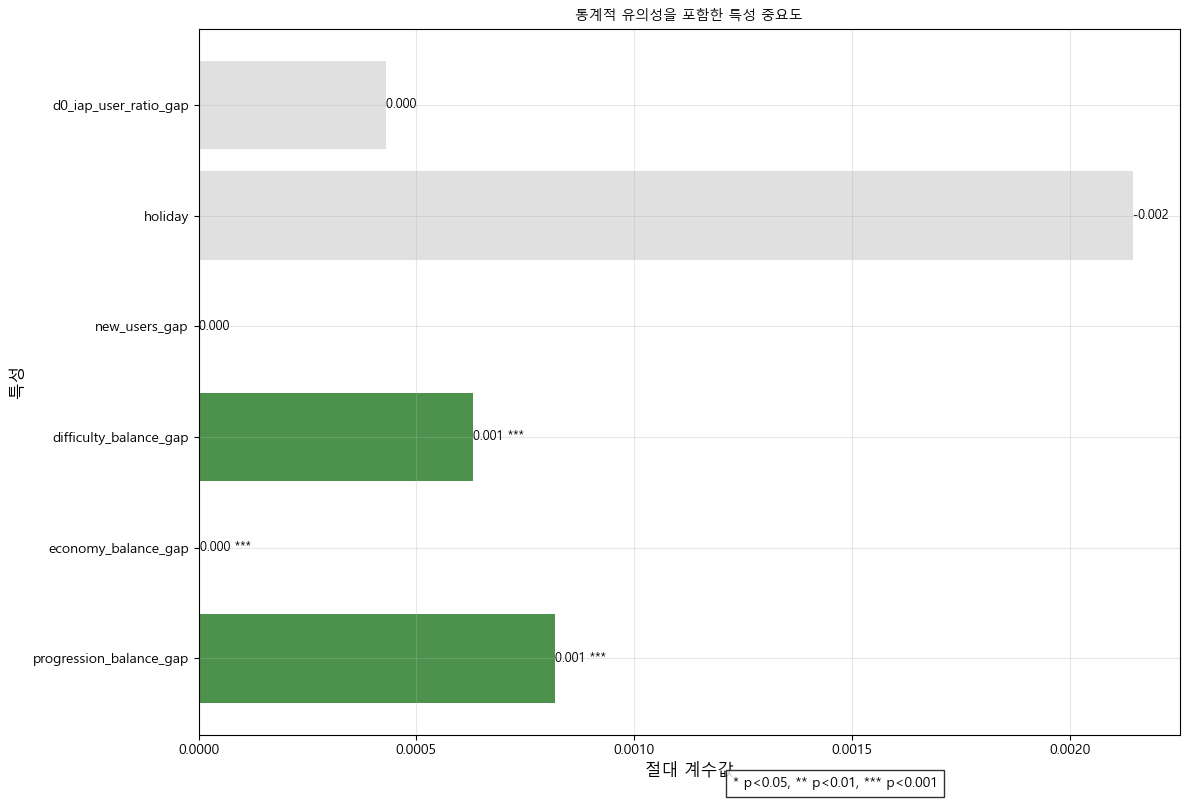

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from linearmodels.iv import IVGMM
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 한글 폰트 설정 - IPython/Jupyter 환경에서의 문제 해결
import matplotlib.font_manager as fm
import matplotlib as mpl
import platform
import os

# 시스템 확인
system = platform.system()

# 폰트 직접 지정 방식 (가장 확실한 방법)
if system == 'Windows':
    if os.path.exists(r'C:\Windows\Fonts\malgun.ttf'):
        font_path = r'C:\Windows\Fonts\malgun.ttf'
    elif os.path.exists(r'C:\Windows\Fonts\gulim.ttc'):
        font_path = r'C:\Windows\Fonts\gulim.ttc'
    else:
        font_path = None
elif system == 'Darwin':  # macOS
    if os.path.exists('/System/Library/Fonts/AppleGothic.ttf'):
        font_path = '/System/Library/Fonts/AppleGothic.ttf'
    else:
        font_path = None
else:  # Linux
    font_candidates = [
        '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        '/usr/share/fonts/nanum/NanumGothic.ttf'
    ]
    font_path = next((f for f in font_candidates if os.path.exists(f)), None)

# 폰트 등록 및 설정
if font_path:
    # print(f"사용할 폰트 경로: {font_path}")
    # 폰트 등록
    font_name = fm.FontProperties(fname=font_path).get_name()
    mpl.font_manager.fontManager.addfont(font_path)
    
    # 글꼴 설정
    plt.rcParams['font.family'] = font_name
else:
    print("적절한 한글 폰트를 찾을 수 없습니다. matplotlib 한글 폰트 패키지를 설치해보세요.")
    try:
        # matplotlib-inline 패키지 설치되어 있다면 사용
        import matplotlib_inline
        print("matplotlib-inline 패키지가 설치되어 있습니다. 이 설정을 시도합니다.")
        mpl.rc('font', family='NanumGothic')
    except ImportError:
        # 대체 방법: 기본 폰트 중에서 최대한 한글을 지원하는 것 사용
        mpl.rc('font', family='DejaVu Sans')

# 추가 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# matplotlib 폰트 전체에 적용될 기본 폰트 설정 (모든 요소에 적용)
import matplotlib.pyplot as plt

# 모든 그래프 요소에 대해 폰트 설정을 명시적으로 적용하는 함수
def set_korean_fonts_for_plot():
    """모든 그래프 요소에 한글 폰트를 적용합니다."""
    plt.rcParams['font.family'] = 'sans-serif'
    if font_path:
        font_prop = fm.FontProperties(fname=font_path)
        plt.title('한글 테스트', fontproperties=font_prop)
        plt.xlabel('한글 테스트', fontproperties=font_prop)
        plt.ylabel('한글 테스트', fontproperties=font_prop)
        return font_prop
    return None


# 한글 폰트 객체 생성 (이후 모든 그래프에서 직접 지정 가능)
if font_path:
    korean_font = fm.FontProperties(fname=font_path)
else:
    korean_font = None

# 📌 모델 예측값 계산
y_actual = y.values
params = results.params
X_with_endog = X.copy()
X_with_endog[['progression_balance_gap', 'economy_balance_gap', 'difficulty_balance_gap']] = endog

y_pred = np.sum(X_with_endog.values * params.values, axis=1)

# 📌 시각화를 위한 DataFrame 생성
pred_df = pd.DataFrame({
    'Date': df.index[:len(y_actual)],  # 인덱스 맞추기
    'Actual': y_actual,
    'Predicted': y_pred
})

# 📌 오차 지표 계산
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

print(f"📊 모델 성능 지표:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"결정계수(R-squared): {r2:.4f}")

# 1️⃣ **실제 vs 예측값 플롯**
plt.figure(figsize=(14, 8))
plt.plot(pred_df['Date'], pred_df['Actual'], label='실제 D1 Retention', linewidth=2)
plt.plot(pred_df['Date'], pred_df['Predicted'], label='예측 D1 Retention', linewidth=2, linestyle='--')

plt.fill_between(pred_df['Date'], pred_df['Predicted'] - rmse, pred_df['Predicted'] + rmse,
                 alpha=0.2, color='gray', label=f'오차 범위 (RMSE: {rmse:.4f})')

plt.title('실제 vs 예측 D1 Retention (IV-GMM 모델)', fontsize=16)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('D1 Retention', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2️⃣ **잔차 플롯**
pred_df['Residuals'] = pred_df['Actual'] - pred_df['Predicted']
plt.figure(figsize=(14, 4))
plt.plot(pred_df['Date'], pred_df['Residuals'], color='red', marker='o', linestyle='-', linewidth=1, markersize=3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(pred_df['Date'], 0, pred_df['Residuals'], alpha=0.2, color='red')

plt.title('시간에 따른 잔차', fontsize=14)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('잔차 값', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3️⃣ **특성 중요도 플롯 (계수값 기준)**

importance_df = pd.DataFrame({
    'Feature': params.index[1:],  # 상수 제거
    'Coefficient': params.values[1:]
})
importance_df['Abs_Coefficient'] = np.abs(importance_df['Coefficient'])
importance_df.sort_values('Abs_Coefficient', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Abs_Coefficient'], color='green', alpha=0.7)

for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{importance_df['Coefficient'].iloc[i]:.3f}", va='center', fontsize=9)

plt.title('특성 중요도 (절대 계수값)', fontsize=16)
plt.xlabel('절대 계수값', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# p-값에 기반한 통계적 유의성 수준을 보여주는 두 번째 중요도 플롯 생성
# 특성, 계수, p-값이 있는 DataFrame 생성
p_values = results.pvalues
features = params.index[1:]  # 상수항 건너뛰기
importance_df_with_pvals = pd.DataFrame({
    'Feature': features,
    'Coefficient': params.values[1:],
    'P_Value': p_values.values[1:]
})

# TypeError 방지를 위해 Feature 열을 문자열로 변환
importance_df_with_pvals['Feature'] = importance_df_with_pvals['Feature'].astype(str)

# p-값(통계적 유의성)으로 정렬
importance_df_with_pvals.sort_values('P_Value', inplace=True)

# 유의성 수준 마커 정의
def significance_marker(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# 유의성 마커 추가
importance_df_with_pvals['Significance'] = importance_df_with_pvals['P_Value'].apply(significance_marker)

# 플롯 생성
plt.figure(figsize=(12, 8))
bar_colors = ['darkgreen' if x < 0.05 else 'lightgray' for x in importance_df_with_pvals['P_Value']]
bars = plt.barh(importance_df_with_pvals['Feature'], np.abs(importance_df_with_pvals['Coefficient']), color=bar_colors, alpha=0.7)

# 텍스트로 계수값 및 유의성 마커 추가 (텍스트 위치 조정)
for i, bar in enumerate(bars):
    # 바의 끝에 텍스트가 들어가도록 위치 조정
    plt.text(
        bar.get_width(),  # 텍스트가 바의 오른쪽에 가까워지도록
        bar.get_y() + bar.get_height()/2,
        f"{importance_df_with_pvals['Coefficient'].iloc[i]:.3f} {importance_df_with_pvals['Significance'].iloc[i]}",
        va='center', ha='left', fontsize=9
    )

plt.title('통계적 유의성을 포함한 특성 중요도', fontsize=16, fontproperties=korean_font)
plt.xlabel('절대 계수값', fontsize=12, fontproperties=korean_font)
plt.ylabel('특성', fontsize=12, fontproperties=korean_font)
plt.grid(True, alpha=0.3)

# 유의성 수준에 대한 범례 추가
plt.figtext(0.7, 0.01, "* p<0.05, ** p<0.01, *** p<0.001", ha="center", fontsize=10, 
            bbox={"facecolor":"white", "alpha":0.8, "pad":5}, fontproperties=korean_font)

plt.tight_layout()
plt.show()
